# 온라인 학습을 적용한 LSTM 예제

* 배치 학습으로 학습한 LSTM 모델의 성능과 온라인 학습을 적용한 LSTM 모델의 성능 비교

## LSTM 모델 정의

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    
    def __init__(self, hidden_dim, fc_dim, targen_len, device):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_layer = nn.LSTM(1, hidden_dim, 1, batch_first=True)
        self.activation = nn.ReLU()
        self.fc_layer = nn.Sequential(
            nn.Linear(hidden_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, targen_len))
        self.device = device
        
    def forward(self, x):
        
        # reset h0, c0
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(self.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(self.device)
        
        _, (out, _) = self.lstm_layer(x, (h0, c0))
        out = out.squeeze(0)
        out = self.activation(out)
        out = self.fc_layer(out)
        return out

def init_weight(m):
  if type(m) == nn.Linear:
      nn.init.xavier_uniform_(m.weight)

## 배치 학습 함수

In [ ]:
def batch_train(model, trainset, validset, lr, epoch, batch_size, device):

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    train_losses = []
    valid_losses = []
    for i in range(epoch):
        
        model.train()
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        train_loss = 0.
        
        for _, (train_x, train_y) in enumerate(train_loader):
            train_x, train_y = train_x.to(device), train_y.to(device)
            optimizer.zero_grad()
            pred = model(train_x)
            loss = loss_fn(pred, train_y.squeeze(1))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
               
        with torch.no_grad():
            model.eval()
            valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=True)
            valid_loss = 0.
            for _, (valid_x, valid_y) in enumerate(valid_loader):
                valid_x, valid_y = valid_x.to(device), valid_y.to(device)
                pred = model(valid_x)
                loss = loss_fn(pred, valid_y.squeeze(1))
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        
    return train_losses, valid_losses

def batch_test(model, testset, device):
    model.eval()
    preds = []    
    test_loader = DataLoader(testset, batch_size=1)   
    with torch.no_grad():
        for _, (test_x, test_y) in enumerate(test_loader):
            test_x, test_y = test_x.to(device), test_y.to(device)
            pred = model(test_x)
            preds.append(pred.item())
    return preds

## 온라인 학습 함수

In [ ]:
def online_test(model, test_x, test_y, device, lr):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    model.train()
    test_x, test_y = test_x.to(device), test_y.to(device)
    optimizer.zero_grad()
    pred = model(test_x)
    loss = loss_fn(pred, test_y.squeeze(1))
    loss.backward()
    optimizer.step()
    return pred.item()

## 데이터셋 및 plot 함수 정의

In [ ]:
import math
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt

class TSdataset(Dataset):
    
    def __init__(self, data, window_len, target_len):
        
        self.data = data
        self.window_len = window_len
        self.target_len = target_len
        self.seq_len = window_len + target_len
        
    def __len__(self):
        return math.floor((len(self.data)-self.seq_len)/self.target_len)
    
    def __getitem__(self, index):
        index = self.target_len*index
        seq = self.data[index:index + self.seq_len]
        x = seq[:self.window_len]
        y = seq[self.window_len:]
        
        return torch.tensor(x).float(), torch.tensor(y).float()

def plot_1c(data, title):
    data = pd.Series(data)
    data.plot(title = title)
    plt.show()

def plot_2c(data1, data2, name1, name2, title):
    min_len = len(data1)
    if len(data1) > len(data2):
        min_len = len(data2)
    plot = pd.DataFrame()
    plot[name1] = data1[:min_len]
    plot[name2] = data2[:min_len]
    plot.plot(title = title)
    plt.show()

## 배치 학습 결과

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


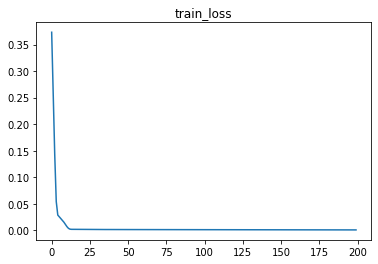

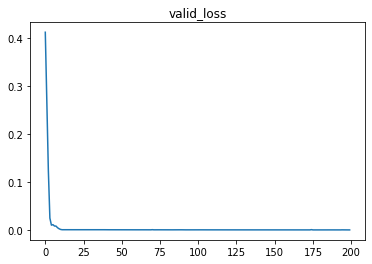

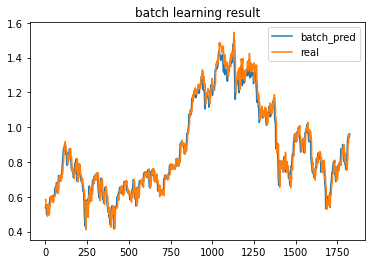

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.utils.data import DataLoader

data = pd.read_csv('https://raw.githubusercontent.com/hrbae/LG_AI_training/main/M2_System%20Optimization%20by%20ML/Online%20Learning%20Practice/kospi.csv', index_col=0)

window_len = 7
target_len = 1
device = torch.device('cuda')

train_data, test_data = train_test_split(data,train_size = 0.5, shuffle = False)
test_data = np.concatenate((train_data[-window_len:], test_data), axis=0)

train_data, valid_data = train_test_split(train_data, test_size = 0.1, shuffle = False)
valid_data = np.concatenate((train_data[-window_len:], valid_data), axis = 0)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
valid_data = scaler.transform(valid_data)
test_data = scaler.transform(test_data)
trainset = TSdataset(train_data, window_len, target_len)
validset = TSdataset(valid_data, window_len, target_len)
testset = TSdataset(test_data, window_len, target_len)

batch_model = LSTM(128, 256, target_len, device).to(device)
batch_model.apply(init_weight)

train_losses,valid_losses = batch_train(batch_model, trainset, validset, 0.0001, 200, 64, device)
plot_1c(train_losses, 'train_loss')
plot_1c(valid_losses, 'valid_loss')

batch_preds = pd.Series(batch_test(batch_model, testset, device))
plot_2c(batch_preds, test_data, 'batch_pred', 'real', 'batch learning result')

## 온라인 학습 결과

학습율에 따라 예측 결과가 달라짐을 확인할 수 있음

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


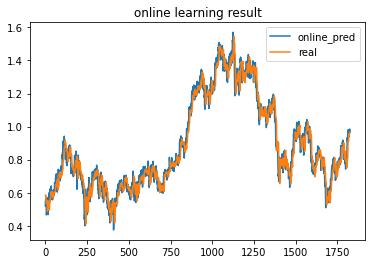

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/hrbae/LG_AI_training/main/M2_System%20Optimization%20by%20ML/Online%20Learning%20Practice/kospi.csv', index_col=0)

window_len = 7
target_len = 1
device = torch.device('cuda')

train_data, test_data = train_test_split(data,train_size = 0.5, shuffle = False)
test_data = np.concatenate((train_data[-window_len:], test_data), axis=0)

train_data, valid_data = train_test_split(train_data, test_size = 0.1, shuffle = False)
valid_data = np.concatenate((train_data[-window_len:], valid_data), axis = 0)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
valid_data = scaler.transform(valid_data)
test_data = scaler.transform(test_data)
trainset = TSdataset(train_data, window_len, target_len)
validset = TSdataset(valid_data, window_len, target_len)
testset = TSdataset(test_data, window_len, target_len)

online_model = LSTM(128, 256, target_len, device).to(device)
online_model.apply(init_weight)

train_losses, valid_losses = batch_train(online_model, trainset, validset, 0.0001, 200, 64, device)
test_loader = DataLoader(testset, batch_size = 1)
online_preds = []
for _, (test_x, test_y) in enumerate(test_loader):
  pred = online_test(online_model, test_x, test_y, device, 0.01)
  online_preds.append(pred)
plot_2c(pd.Series(online_preds),test_data, 'online_pred', 'real', 'online learning result')